In [1]:
from tqdm.notebook import tqdm
tqdm.pandas()
import os
import pandas as pd
import tensorflow as tf

In [2]:
df = pd.read_csv("./minwook_data.csv")
df = df.loc[df['class'] != 0]
df['class'] -= 1
df.sample(10)

,class,text
1463,1,니네집 등산복 집한다며? 시내에서 크게? 아응 돈을 아주 쓸어담는다더라? 그정도는 ...
624,3,당신만 아니었으면 얘도 더 잘 됐어. 그래. 무능한 아빠면 자상하기라도 했어야지. ...
759,1,어이 동생 잘 지냈어? 요즘 알바 한다며? 응응 맥도날드에서 알바 시작했어. 근데 ...
1440,0,너 이 자식 죽일 테다 아버지 살려주세요 감히 아버지를 속여? 제발 한 번만 봐주세...
1719,3,너 엄마 없어? 아.응. 왜 ? 뭐때문에 .? 아빠가. 술 좋아하셔서 . 아? 술?...
3025,1,가진 거 다 내놔 뭐래는거야 이 사람이 지금 내말 안들으면 후회할텐데 왜 그러세요 ...
3063,0,야 1반 찐따 왜 불러. 니네 누나는 너랑 다르게 찐따는 아니더라 반대던데? 어.어...
156,1,우와 이거 예쁘다. 머야 이거? 이거 입생로랑 지갑이야. 엄청 비싼건데 예쁘다. 영...
2415,1,어머니 저 진짜 돈 없어요 애미야 좋은 계가 하나 있다니까? 이돈은 가지고있다가 둘...
2040,0,저새끼는 왜 말도 안듣고 시키는것도 안하지? 그러게 말이야 한대 맞아야 정신차리려나...


In [3]:
from transformers import ElectraTokenizer

pretrained_model = "monologg/koelectra-small-v3-discriminator"
tokenizer = ElectraTokenizer.from_pretrained(pretrained_model)

df = df.replace(r'\\n', '', regex=True) # Delete [SEP]
assert df['text'].str.contains(r'\n').any() == False
tokenizer.decode(tokenizer.encode(df['text'][1090]))

'[CLS] 여기 음식이 왜이러죠 음식이 뭐가 문제인가요 손님 음식 맛이 이상하잖아요 저희는 메뉴얼대로 만들어서 손님 입맛에 안맞을수는 있습니다. 아 저는 한숟가락 밖에 안먹었으니 환불해주세요 손님 음식은 제대로 나왔기때문에 환불은 힘들거같습니다. 아니 한숟갈만 먹었는데 돈을 다내라고요? 네 손님 저희메뉴얼상 환불은 힘들거같습니다. 아니 뭐 이런 가게가 다있어. 여기 점장불러와 손님 죄송합니다 잠시만기다려주세요 [SEP]'

In [4]:
def convert_to_input(df, tokenizer, max_length=430):
    input_ids = []
    attention_masks = []
    labels = []

    for i in range(len(df)):
        sentence = df.iloc[i]['text'].replace('.', '')
        encoded = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        labels.append(df.iloc[i]['class'])

    input_ids = tf.concat(input_ids, axis=0)
    attention_masks = tf.concat(attention_masks, axis=0)
    labels = tf.convert_to_tensor(labels, dtype=tf.int32)

    return {
        'input_ids': input_ids,
        'attention_mask': attention_masks
    }, labels


In [5]:
from sklearn.model_selection import train_test_split

SEED = 1024
MAX_LENGTH = 400
BATCH_SIZE = 16

train_df, test_df = train_test_split(
    df, test_size = 0.2, random_state = SEED, stratify=df['class']
)
train_inputs, train_labels = convert_to_input(train_df, tokenizer, max_length=MAX_LENGTH)
test_inputs, test_labels = convert_to_input(test_df, tokenizer, max_length=MAX_LENGTH)
train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_labels)).batch(BATCH_SIZE)

In [6]:
import re
from sklearn.preprocessing import LabelEncoder
from transformers import TFElectraForSequenceClassification
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


MODEL_NAME = 'KoELECTRA_v3_small_multi'
MODEL_CHECK_POINT_PATH = f"{MODEL_NAME}.weights.h5"
MODEL_SAVE_PATH = os.path.join("_model", MODEL_NAME)


callback_earlystopping = EarlyStopping(
    monitor="val_accuracy", min_delta=0.001, patience=2
)

# lr 조절
callback_learningrate_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=1e-6,
)


callback_modelcheckpoint = ModelCheckpoint(
    filepath=MODEL_CHECK_POINT_PATH,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only="True"
)
callbacks = [
    callback_earlystopping,
    callback_learningrate_scheduler,
    callback_modelcheckpoint,
]

EPOCHS = 50
# label index를 0부터 시작해주니까 문제 없이 처리됨, 이전에는 loss nan이 계속 나옴
label2id = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
}
id2label = {v:k for k, v in label2id.items()}

# /device:GPU:0
with tf.device('/device:GPU:0'):
    model = TFElectraForSequenceClassification.from_pretrained(
        pretrained_model,
        num_labels=4,
        id2label=id2label, 
        label2id=label2id,
        from_pt=True,  # Load from PyTorch checkpoint
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, 
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
        metrics=['accuracy']
    )
    history = model.fit(
        train_dataset, 
        epochs=EPOCHS, 
        validation_data=test_dataset,
        callbacks = callbacks,
    )

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'electra.embeddings.position_ids', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing TFElectraForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFElectraForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dens

Epoch 1/50
177/177 [==============================] - 79s 355ms/step - loss: 1.3827 - accuracy: 0.3102 - val_loss: 1.3650 - val_accuracy: 0.4646
Epoch 2/50
177/177 [==============================] - 61s 344ms/step - loss: 1.2422 - accuracy: 0.6274 - val_loss: 1.1117 - val_accuracy: 0.6671
Epoch 3/50
177/177 [==============================] - 61s 344ms/step - loss: 1.0024 - accuracy: 0.7756 - val_loss: 0.8653 - val_accuracy: 0.8314
Epoch 4/50
177/177 [==============================] - 61s 343ms/step - loss: 0.7927 - accuracy: 0.8454 - val_loss: 0.6693 - val_accuracy: 0.8654
Epoch 5/50
177/177 [==============================] - 61s 343ms/step - loss: 0.6167 - accuracy: 0.8745 - val_loss: 0.5568 - val_accuracy: 0.8569
Epoch 6/50
177/177 [==============================] - 61s 344ms/step - loss: 0.4903 - accuracy: 0.8908 - val_loss: 0.4807 - val_accuracy: 0.8683
Epoch 7/50
177/177 [==============================] - 61s 344ms/step - loss: 0.4102 - accuracy: 0.8997 - val_loss: 0.4685 - val_ac

In [7]:
if os.path.exists(MODEL_SAVE_PATH):
    print(f"{MODEL_SAVE_PATH} -- Folder already exists \n")
else:
    os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
    print(f"{MODEL_SAVE_PATH} -- Folder create complete \n")

# save tokenizer, model
model.save_pretrained(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)

_model/KoELECTRA_v3_small_multi -- Folder already exists 



('_model/KoELECTRA_v3_small_multi/tokenizer_config.json',
 '_model/KoELECTRA_v3_small_multi/special_tokens_map.json',
 '_model/KoELECTRA_v3_small_multi/vocab.txt',
 '_model/KoELECTRA_v3_small_multi/added_tokens.json')

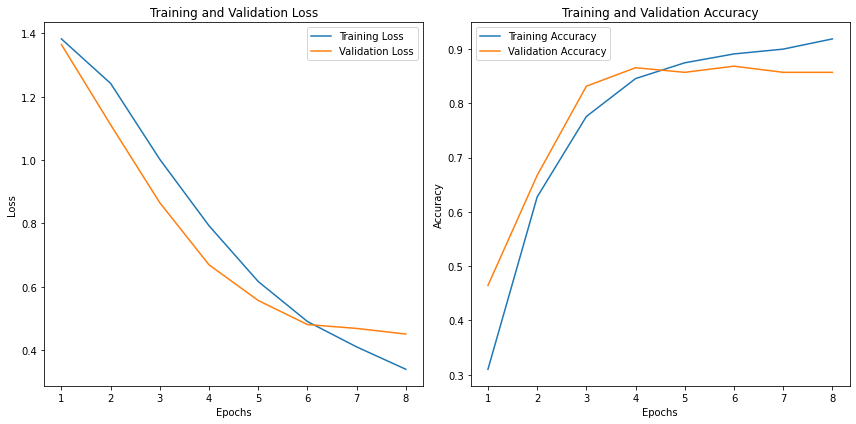

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# 학습 기록 추출

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

# 손실 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.lineplot(x=epochs, y=loss, label='Training Loss')
sns.lineplot(x=epochs, y=val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 정확도 시각화
plt.subplot(1, 2, 2)
sns.lineplot(x=epochs, y=accuracy, label='Training Accuracy')
sns.lineplot(x=epochs, y=val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
from transformers import AutoTokenizer, TFElectraForSequenceClassification

abnormal_tokenizer = AutoTokenizer.from_pretrained(MODEL_SAVE_PATH)
abnormal_model = TFElectraForSequenceClassification.from_pretrained(MODEL_SAVE_PATH)

def get_abnormal_label(text: str) -> int:
    normal_class_id = 0
    
    # 입력 텍스트를 토크나이징합니다.
    inputs = abnormal_tokenizer(text, return_tensors="tf")
    
    # 로드된 모델을 사용하여 로짓(logits)을 예측합니다.
    logits = abnormal_model(**inputs).logits
    
    # softmax 함수를 사용하여 각 클래스에 대한 확률을 계산합니다.
    probabilities = tf.nn.softmax(logits, axis=-1)
    
    # 확률이 가장 높은 클래스 ID를 선택합니다.
    class_id = tf.argmax(probabilities, axis=-1).numpy()[0]
    return class_id

data = df[df['class']==3].sample(10)
for _, row in data.iterrows():
    print(get_abnormal_label(row['text']))

All model checkpoint layers were used when initializing TFElectraForSequenceClassification.

All the layers of TFElectraForSequenceClassification were initialized from the model checkpoint at _model/KoELECTRA_v3_small_multi.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraForSequenceClassification for predictions without further training.


3
3
3
3
3
3
3
3
3
3




1. Batch 32
2. Batch 16